In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
# export
import torch.nn
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli
from librosa.effects import split
from dataclasses import asdict
from scipy.signal import resample_poly
import librosa

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
original_aud = AudioItem.create(files[0])

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

In [ ]:
original_spec = a2s(original_aud)

In [ ]:
type(original_spec[0])

torch.Tensor

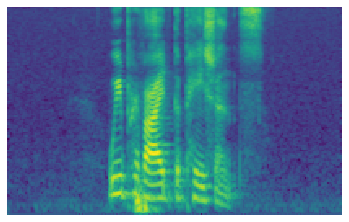

In [ ]:
original_spec.show()

In [ ]:
original_spec.n_fft

1024

## Spectrogram Transforms

###  Crop Time, pad_spectro(internal)

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br> 
    1. Should this be extending RandomTransform? <br>
    2. In spectrogram when we pad with mean value we mess up normalization by altering std dev, how can we use fill values that dont mess things up<br></div>


In [ ]:
#export
def CropTime(duration, pad_mode="zeros"):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Random crops full spectrogram to be length specified in ms by crop_duration'''
        sg = spectro.clone()
        sr, hop = spectro.sr, spectro.hop_length
        w_crop = int((sr*duration)/(1000*hop))+1
        w_sg   = sg.shape[-1]
        if   w_sg <  w_crop: 
            sg_pad = _tfm_pad_spectro(sg, w_crop, pad_mode=pad_mode)
            return AudioSpectrogram.create(sg_pad, settings=spectro.settings)
        elif w_sg == w_crop: return sg
        else:
            crop_start = random.randint(0, int(w_sg - w_crop))
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(duration*sr)
            return AudioSpectrogram.create(sg_crop, settings=spectro.settings)
    return _inner

In [ ]:
#export
def _tfm_pad_spectro(sg, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,y,x = sg.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c,y, zeros_front))
        pad_back = torch.zeros((c,y, width-x-zeros_front))
        return AudioSpectrogram(torch.cat((pad_front, sg, pad_back), 2))
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sg.repeat(1,1,repeats)[:,:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

if width of the spectrogram is less than width of the cropping window -> pad
if they are equal -> return unaltered
if width of spectro > width of cropping window, randomly select the cropping window

In [ ]:
crop_1000ms = CropTime(1000)
crop_2000ms = CropTime(2000)
crop_5000ms = CropTime(5000)
print(f"Audio is {original_aud.duration} seconds")

Audio is 3.28 seconds


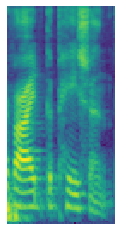

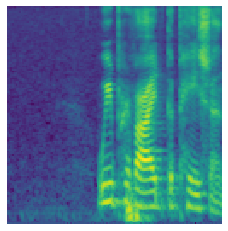

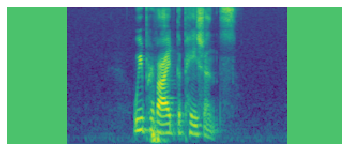

In [ ]:
s1 = crop_1000ms(original_spec)
s1.show()
s2 = crop_2000ms(original_spec)
s2.show()
s5 = crop_5000ms(original_spec)
s5.show()

<div class = "alert alert-block alert-info"><strong>Note:</strong><br> 
    Because a spectrograms duration is dependent on rounding (samples/hop_length usually has a remainder that is padded up to an extra pixel), we cant use exact durations, so we must test_close instead of test_eq. This could be fixed by storing the AudioItems duration when the sg is generated, and also updating the duration manually anytime a Transform occurs that affects the size time axis (x-axis)
</div>


In [ ]:
test_eq(original_spec.settings, s1.settings)
test_eq(original_spec.settings, s5.settings)
test_close(s1.width, int((1/original_spec.duration)*original_spec.width), eps=1.01)
test_close(s2.width, int((2/original_spec.duration)*original_spec.width), eps=1.01)
test_close(s5.width, int((5/original_spec.duration)*original_spec.width), eps=1.01)

In [ ]:
# test pad_mode zeros-after by verifying sg ends with zeros and begins with non-zeros
crop_5000ms = CropTime(5000, pad_mode="zeros-after")
s5 = crop_5000ms(original_spec)
test_eq(s5[:,:,-1], torch.zeros_like(s5)[:,:,-1])
test_ne(s5[:,:,0], torch.zeros_like(s5)[:,:,-1])

In [ ]:
original_spec.duration

3.288

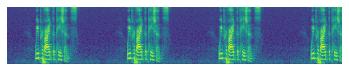

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
crop_12000ms = CropTime(12000, pad_mode="repeat")
s12_repeat = crop_12000ms(original_spec)
s12_repeat.show()
for i in range(original_spec.width):
    test_eq(s12_repeat[:,:,i], s12_repeat[:,:,i+original_spec.width])
    test_eq(s12_repeat[:,:,i], s12_repeat[:,:,i+2*original_spec.width])

In [ ]:
# test bad pad_mode doesnt fail silently
test_fail(CropTime(12000, pad_mode="zerosafter"))

In [ ]:
s1.shape, s2.shape, s5.shape

(torch.Size([1, 128, 63]),
 torch.Size([1, 128, 126]),
 torch.Size([1, 128, 313]))

<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


<div class = "alert alert-block alert-info"> Is it better to use nonlocal here to be able to assign the value of start in the closure?</div>


### SpecAugment

In [ ]:
#export
def MaskFreq(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape
        for _ in range(num_masks):
            mask = torch.ones(size, x) * mask_val    
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

<div class = "alert alert-block alert-warning"> Passing around the settings manually is already fairly clunky, but is especially bad when we have to do it twice when MaskTime hands off to MaskFrequency. We should maybe make a copy of the AudioSpectrogram and then alter the tensor for it's sg rather than cloning out the sg and then building a new object at the end. Or just keep a reference to the parent tensor and pass that along, and have getattr recur looking for settings of the parents</div>


In [ ]:
#export
def MaskTime(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone()
        sg = torch.einsum('...ij->...ji', sg)
        sg = AudioSpectrogram.create(sg, settings=spectro.settings)
        sg = MaskFreq(num_masks, size, start, val, **kwargs)(sg)
        return AudioSpectrogram.create(torch.einsum('...ij->...ji', sg), settings=spectro.settings)
    return _inner

In [ ]:
freq_mask = MaskFreq()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 26.6 ms


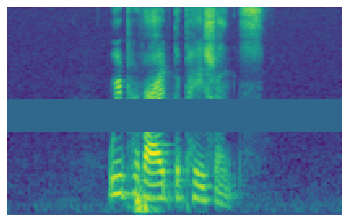

In [ ]:
%%time
freq_mask(original_spec).show()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.5 ms


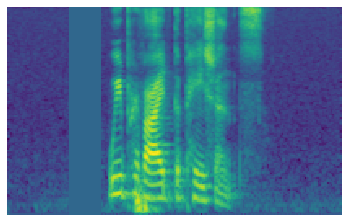

In [ ]:
%%time
time_mask = MaskTime()
time_mask(original_spec).show()

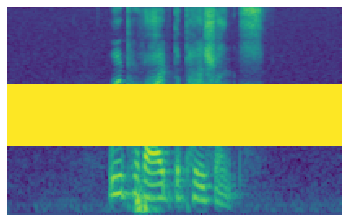

In [ ]:
# create a random frequency mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
freq_mask_test = MaskFreq(size=size, start=start, val=val)
sg_test = freq_mask_test(original_spec)
sg_test.show()
test_eq(sg_test[:,start:start+size,:], val*torch.ones_like(original_spec)[:,start:start+size,:])

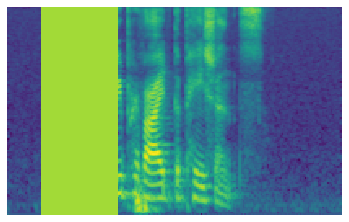

In [ ]:
# create a random time mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
time_mask_test = MaskTime(size=size, start=start, val=val)
sg_test = time_mask_test(original_spec)
sg_test.show()
test_eq(sg_test[:,:,start:start+size], val*torch.ones_like(original_spec)[:,:,start:start+size])

## SG Roll

In [ ]:
def TfmRoll(max_shift_pct=0.7, direction=0, **kwargs):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        if len(spectro.shape) < 2:
            raise Exception('Cannot apply spectrogram rolling to a signal')
        nonlocal direction
        direction = random.choice([-1, 1]) if direction == 0 else direction
        sg = spectro.clone()
        c, height, width = sg.shape
        roll_by = int(width*random.random()*max_shift_pct*direction)
        sg = sg.roll(roll_by, dims=2)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
roller = TfmRoll()

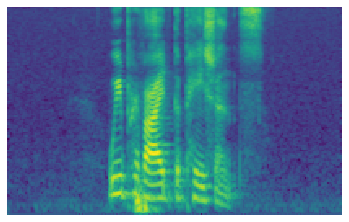

In [ ]:
original_spec.show()

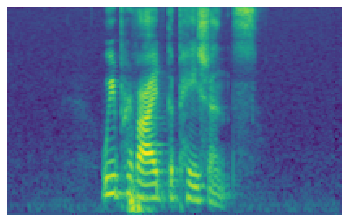

In [ ]:
roller(original_spec).show()

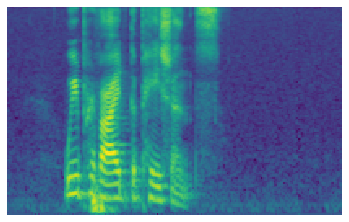

In [ ]:
roller(original_spec).show()

In [ ]:
#fails occasionally when by chance roll is 0, but i dont want to change to >= or <= because 
#it wont detect a broken roll! Could maybe scrap this test, it's overly complex
def _first_non_zero_col(t):
    for i in range(t.shape[2]):
        if(t[0,0,i].item() == 1): return i
roll_spec = a2s(original_aud)
mid = int((roll_spec.width/2))-5
test_spec = torch.zeros_like(roll_spec)
test_spec[:,:,mid:mid+10] = 1
roll_spec.data = test_spec
left_roller = TfmRoll(max_shift_pct=0.4, direction=-1)
left_spec = left_roller(roll_spec).data
right_roller = TfmRoll(max_shift_pct=0.4, direction=1)
right_spec = right_roller(roll_spec).data
ostart, lstart, rstart = map(_first_non_zero_col, (test_spec, left_spec, right_spec))
test(lstart, ostart, operator.lt)
test(rstart, ostart, operator.gt)

## Delta/Accelerate 

In [ ]:
#export
def _torchdelta(mel:AudioSpectrogram, order=1, width=9):
    '''Converts to numpy, takes delta and converts back to torch, needs torchification'''
    if(mel.shape[1] < width): 
        raise ValueError(f'''Delta not possible with current settings, inputs must be wider than 
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width''')
    return AudioSpectrogram(torch.from_numpy(librosa.feature.delta(mel.numpy(), order=order, width=width)))

In [ ]:
def Delta(width=9):
    td = partial(_torchdelta, width=width)
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        new_channels = [torch.stack([c, td(c, order=1), td(c, order=2)]) for c in spectro]
        return AudioSpectrogram.create(torch.cat(new_channels), settings=spectro.settings)
    return _inner

In [ ]:
delta = Delta()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape torch.Size([3, 128, 206])


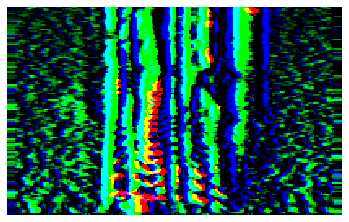

In [ ]:
d = delta(original_spec)
print("Shape",d.shape)
d.show()
test_eq(d.nchannels, 3*original_spec.nchannels)
test_eq(d.shape[1:], original_spec.shape[1:])
test_ne(d[0],d[1])

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


## Image resizing

<div class = "alert alert-block alert-info"> This should probably be refactored to use visions size transform since it already exists</div>


In [ ]:
def TfmResize(size, interp_mode="bilinear", **kwargs):
    '''Temporary fix to allow image resizing transform'''
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal size
        if isinstance(size, int): size = (size, size)
        sg = spectro.clone()
        c,y,x = sg.shape
        sg = F.interpolate(sg.unsqueeze(0), size=size, mode=interp_mode, align_corners=False).squeeze(0)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
# Test when size is an int
size=224
resizer = TfmResize(size)
resized = resizer(original_spec)
print("Original Shape: ", original_spec.shape)
print("Resized Shape :" , resized.shape)
test_eq(resized.shape[1:], torch.Size([size,size]))

Original Shape:  torch.Size([1, 128, 206])
Resized Shape : torch.Size([1, 224, 224])


Original Shape:  torch.Size([1, 128, 206])
Resized Shape : torch.Size([1, 124, 581])


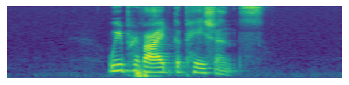

In [ ]:
# Test when size is a tuple with unequal values
size_tup=(124,581)
resizer_tup = TfmResize(size_tup)
resized_tup = resizer_tup(original_spec)
print("Original Shape: ", original_spec.shape)
print("Resized Shape :" , resized_tup.shape)
resized_tup.show()
test_eq(resized_tup.shape[1:], torch.Size(size_tup))

## Pipeline testing

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Allow beginner to choose height and width of output spectrogram and have settings adjust accordingly</div>


In [ ]:
files

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True (object,object) -> encodes (object,object) -> decodes

In [ ]:
sg_cfg = MelSpectrogramConfig(hop_length=256, n_fft=2048)
pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg), CropTime(1000), MaskTime(num_masks=2, size=4), MaskFreq(val=42)], as_item=True)

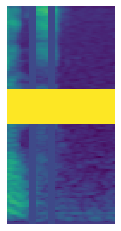

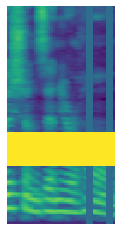

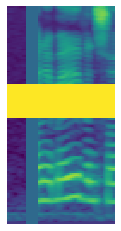

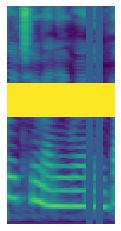

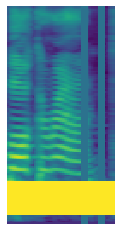

In [ ]:
for i in range(5): pipe.show(pipe(i))

## Signal Transforms

<div class = "alert alert-block alert-info"> CropSignal and CropTime can either be merged into one function, or they can outsource the bulk of their behavior to a shared cropping function</div>

In [ ]:
#export
def CropSignal(duration, pad_mode="zeros"):
    def _inner(ai: AudioItem)->AudioItem:
        '''Crops signal to be length specified in ms by duration, padding if needed'''
        sig = ai.sig.clone()
        orig_samples = ai.nsamples
        crop_samples = int((duration/1000)*ai.sr)
        if orig_samples < crop_samples: 
            sig_pad = _tfm_pad_signal(sig, crop_samples, pad_mode=pad_mode)
            return AudioItem((sig_pad, ai.sr, ai.path))
        elif orig_samples == crop_samples: return AudioItem((sig, ai.sr, ai.path))
        else:
            crop_start = random.randint(0, int(orig_samples-crop_samples))
            sig_crop = sig[:,crop_start:crop_start+crop_samples]
            return AudioItem((sig_crop, ai.sr, ai.path))
    return _inner

In [ ]:
#export
def _tfm_pad_signal(sig, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,x = sig.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c, zeros_front))
        pad_back = torch.zeros((c, width-x-zeros_front))
        return torch.cat((pad_front, sig, pad_back), 1)
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sig.repeat(1,repeats)[:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

In [ ]:
cropsig_1000ms = CropSignal(1000)
cropsig_2000ms = CropSignal(2000)
cropsig_5000ms = CropSignal(5000, pad_mode="zeros-after")
print(f"Audio is {original_aud.duration} seconds")

Audio is 3.28 seconds


In [ ]:
aud1s = cropsig_1000ms(original_aud)
aud2s = cropsig_2000ms(original_aud)
aud5s = cropsig_5000ms(original_aud)

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


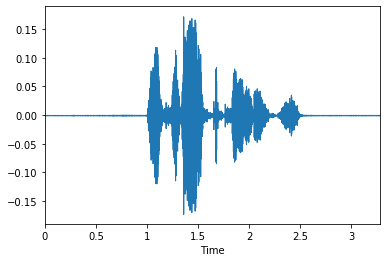

In [ ]:
original_aud.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


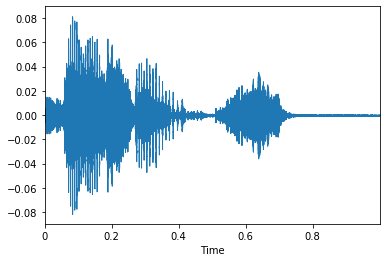

In [ ]:
aud1s.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


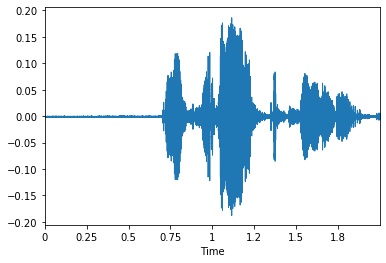

In [ ]:
aud2s.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


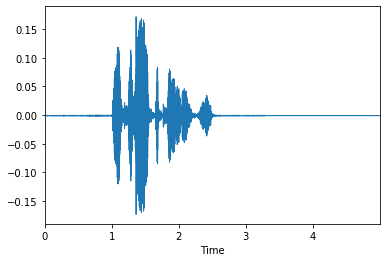

In [ ]:
aud5s.show()

In [ ]:
test_eq(aud1s.nsamples, 1*original_aud.sr)
test_eq(aud2s.nsamples, 2*original_aud.sr)
test_eq(aud5s.nsamples, 5*original_aud.sr)
test_eq(aud1s.duration, 1)
test_eq(aud2s.duration, 2)
test_eq(aud5s.duration, 5)

In [ ]:
# test AudioToSpec->CropTime and CropSignal->AudioToSpec will result in same size images
crop_dur = random.randint(1000,5000)
pipe_cropsig  = Pipeline([oa, AudioToSpec(hop_length=128), CropTime(crop_dur)], as_item=True)
pipe_cropspec = Pipeline([oa, CropSignal(crop_dur), AudioToSpec(hop_length=128), ], as_item=True)
for i in range(50):
    test_eq(pipe_cropsig(i).width, pipe_cropspec(i).width)

In [ ]:
# test pad_mode zeros-after by verifying signal ends with zeros and begins with non-zeros
test_aud = AudioItem((torch.rand_like(original_aud.sig), 16000, None))
test_aud.hear()
cropsig_pad = CropSignal(5000, pad_mode="zeros-after")
z_after = cropsig_pad(test_aud)
z_after.hear()
test_eq(z_after.sig[:,-10:], torch.zeros_like(z_after.sig)[:,-10:])
test_ne(z_after.sig[:,0:10] , z_after.sig[:,-10:])

In [ ]:
# test pad_mode zeros-after by verifying signal begins/ends with zeros
test_aud.hear()
cropsig_pad = CropSignal(5000, pad_mode="zeros")
z_after = cropsig_pad(test_aud)
z_after.hear()
test_eq(z_after.sig[:,0:2], z_after.sig[:,-2:])

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


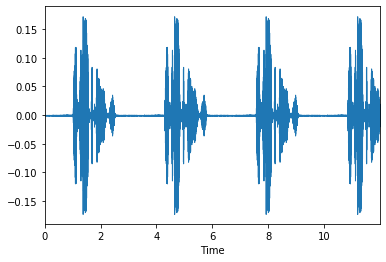

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
cropsig_repeat = CropSignal(12000, pad_mode="repeat")
ai_repeat = cropsig_repeat(original_aud)
ai_repeat.show()
sig_repeat = ai_repeat.sig
for i in range(original_aud.nsamples):
    test_eq(sig_repeat[:,i], sig_repeat[:,i+original_aud.nsamples])
    test_eq(sig_repeat[:,i], sig_repeat[:,i+2*original_aud.nsamples])

In [ ]:
# test bad pad_mode doesnt fail silently
test_fail(CropSignal(12000, pad_mode="tenchify"))

# Preprocessing functions

##  Remove Silence

In [ ]:
#export
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

def RemoveSilence(remove_type, threshold=20, pad_ms=20):
    def _inner(ai:AudioItem)->AudioItem:
        '''Split signal at points of silence greater than 2*pad_ms '''
        if remove_type is None: return ai
        padding = int(pad_ms/1000*ai.sr)
        if(padding > ai.nsamples): return ai
        actual = ai.sig.clone()
        splits = split(actual.numpy(), top_db=threshold, hop_length=padding)
        if remove_type == "split":
            sig =  [actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                    for (a, b) in _merge_splits(splits, padding)]
        elif remove_type == "trim":
            sig = [actual[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
        elif remove_type == "all":
            sig = [torch.cat([actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                              for (a, b) in _merge_splits(splits, padding)], dim=1)]
        else: 
            raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not '{cfg.remove_silence}'.")
        return AudioItem((*sig, ai.sr, ai.path))
    return _inner

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br/> 
    1. Fix display of multiple audios, plots are messed up<br/>
    2. Add in longer clips (whale) and do more extensive testing<br/></div>


File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


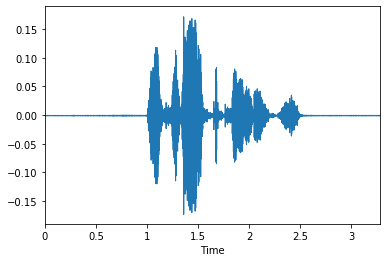

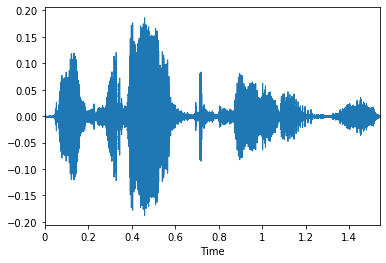

In [ ]:
silence_audio = RemoveSilence("trim", threshold=20, pad_ms=20)(original_aud)
original_aud.show()
silence_audio.show()
#test that at least a half second of silence is being removed
test(silence_audio.nsamples + 8000, original_aud.nsamples, operator.le)

In [ ]:
#test that nothing is removed from audio that doesnt contain silence
test_aud = AudioItem((torch.rand_like(original_aud.sig), 16000, None))
print("Random Noise, no silence")
test_aud.hear()
for rm_type in ["trim", "all", "split"]:
    silence_audio_trim = RemoveSilence(rm_type, threshold=20, pad_ms=20)(test_aud)
    test_eq(test_aud.nsamples, silence_audio_trim.nsamples)

Random Noise, no silence


## Resampling

In [ ]:
#export
def Resample(sr_new):
    def _inner(ai:AudioItem)->AudioItem:
        '''Resample using faster polyphase technique and avoiding FFT computation'''
        if(ai.sr == sr_new): return AudioItem(ai)
        sig_np = ai.sig.numpy()
        sr_gcd = math.gcd(ai.sr, sr_new)
        resampled = resample_poly(sig_np, int(sr_new/sr_gcd), int(ai.sr/sr_gcd), axis=-1)
        resampled = resampled.astype(np.float32)
        return AudioItem((torch.from_numpy(resampled), sr_new, ai.path))
    return _inner

In [ ]:
#Make sure if old and new sample rates are the same, a new identical AudioItem is returned
no_resample_needed = Resample(original_aud.sr)(original_aud)
assert(not no_resample_needed is original_aud)
test_eq(original_aud.sr, no_resample_needed.sr)
test_eq(original_aud.sig, no_resample_needed.sig)

In [ ]:
#test and hear realistic sample rates
print("Original, Sample Rate", original_aud.sr)
original_aud.hear()
for rate in [4000,8000,22050,44100]:
    resampled = Resample(rate)(original_aud)
    orig_samples = original_aud.nsamples
    re_samples = resampled.nsamples
    print("Sample Rate", rate)
    resampled.hear()
    test_eq(re_samples, orig_samples//(original_aud.sr/rate))

Original, Sample Rate 16000


Sample Rate 4000


Sample Rate 8000


Sample Rate 22050


Sample Rate 44100


In [ ]:
%%time
# polyphase does bad with random resample rates ~74ms per, but this
# should never happen because of relatively fixed sample rates
# bad == low gcd between old and new sample rate
for i in range(100):
    random_sr = random.randint(16000, 72000)
    random_upsample = Resample(random_sr)(original_aud)
    num_samples = random_upsample.nsamples
    test_close(num_samples, abs(orig_samples//(original_aud.sr/random_sr)), eps=1.1)

CPU times: user 26.4 s, sys: 912 ms, total: 27.4 s
Wall time: 6.84 s


# Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 01b_dispatch.ipynb.
Converted 01c_transform.ipynb.
Converted 02_script.ipynb.
Converted 03_torch_core.ipynb.
Converted 03a_layers.ipynb.
Converted 04_dataloader.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_data_block.ipynb.
Converted 08_vision_core.ipynb.
Converted 09_vision_augment.ipynb.
Converted 10_pets_tutorial.ipynb.
Converted 11_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 15a_vision_models_unet.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 21_vision_learner.ipynb.
Converted 22_tutorial_imagenette.ipynb.
Converted 23_tutorial_